# adult dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    LossValEvaluator,
    RandomEvaluator
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


ModuleNotFoundError: No module named 'lossval'

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [2]:
dataset_name = "adult"
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels, 
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.7760000228881836


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    # LeaveOneOut(), # leave one out
    # InfluenceSubsample(num_models=1000), # influence function
    # DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    # KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    # DataShapley(cache_name=f"cached"), # Data-Shapley
    # BetaShapley(cache_name=f"cached"), # Beta-Shapley
    # DataBanzhaf(num_models=1000), # Data-Banzhaf
    # AME(num_models=1000), # Average Marginal Effects
    # DataOob(num_models=1000), # Data-OOB
    # LavaEvaluator(),
    LossValEvaluator(is_classification=True) # LossVal
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000671


100%|██████████| 1000/1000 [00:19<00:00, 52.05it/s]


Elapsed time LeaveOneOut(): 0:00:19.263986


100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:12.102394


100%|██████████| 2000/2000 [00:10<00:00, 186.72it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:10.770361


100%|██████████| 999/999 [00:00<00:00, 15605.22it/s]

Elapsed time KNNShapley(k_neighbors=100): 0:00:00.089215
Start: marginal contribution computation



100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


gr_stat=100


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


gr_stat=100


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


gr_stat=100


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


gr_stat=100


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

gr_stat=1.0226953085109485
Total number of trained models to estimate marginal contributions: 61868
Done: marginal contribution computation


Elapsed time DataShapley(cache_name=cached): 0:05:15.396426
Elapsed time BetaShapley(cache_name=cached): 0:00:00.002724


100%|██████████| 1000/1000 [00:15<00:00, 62.72it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:15.963546


100%|██████████| 1000/1000 [00:19<00:00, 50.45it/s]


Elapsed time AME(num_models=1000): 0:00:59.742213


100%|██████████| 1000/1000 [00:27<00:00, 37.02it/s]


Elapsed time DataOob(num_models=1000): 0:00:27.018882


Elapsed time LavaEvaluator(): 0:00:00.204240
CPU times: user 1h 9min 17s, sys: 14min 47s, total: 1h 24min 5s
Wall time: 7min 40s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/adult_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.048077
BetaShapley(cache_name=cached),0.527578
DVRL(rl_epochs=2000),0.477477
DataBanzhaf(num_models=1000),0.298063
DataOob(num_models=1000),0.605607
DataShapley(cache_name=cached),0.510345
InfluenceSubsample(num_models=1000),0.314540
KNNShapley(k_neighbors=100),0.596558
LavaEvaluator(),0.009950
LeaveOneOut(),0.103004


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

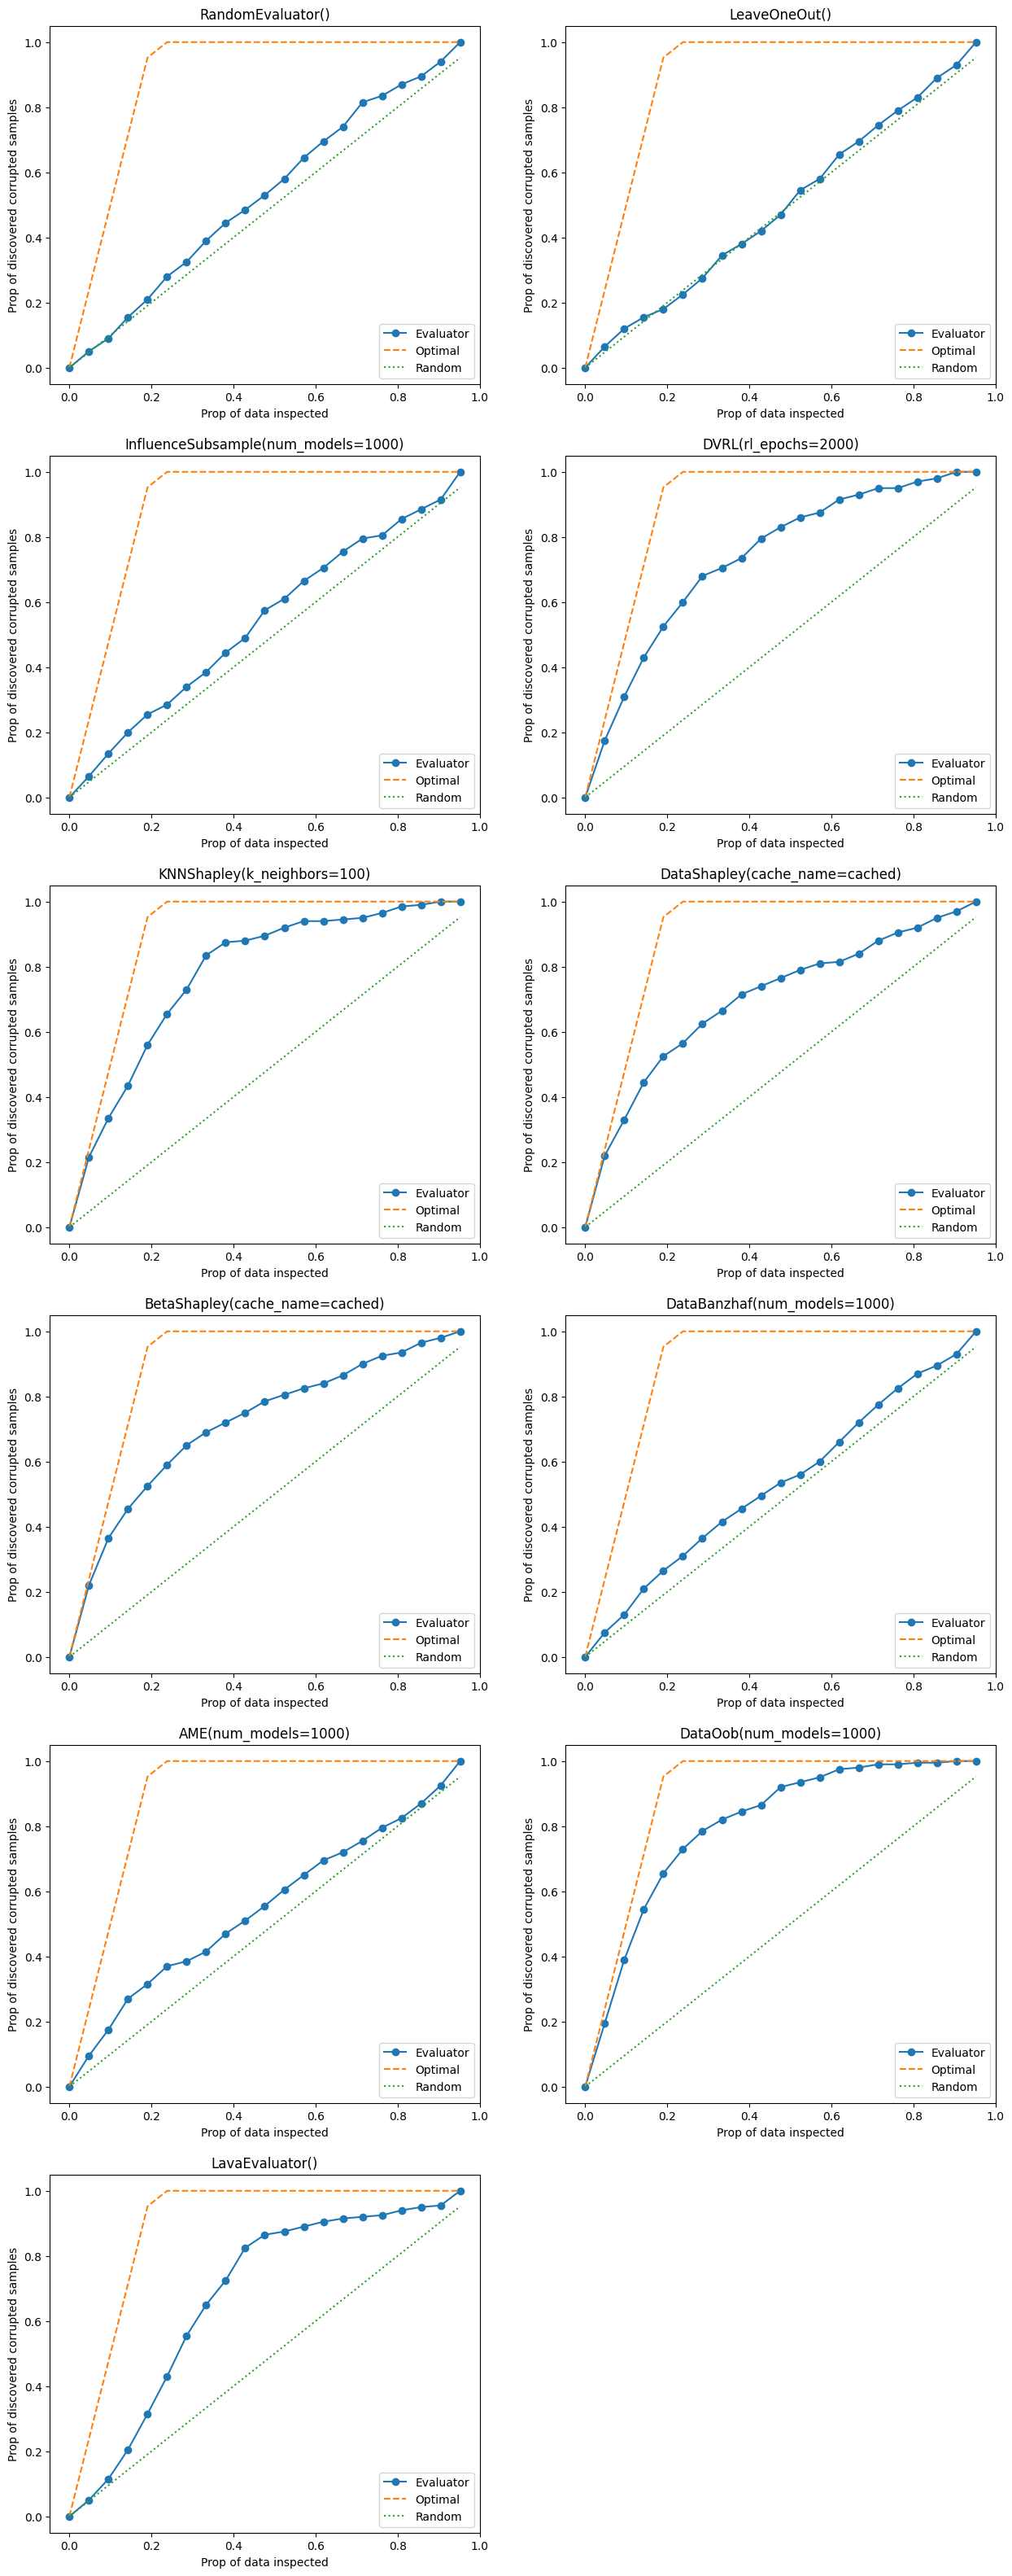

In [7]:
fig = plt.figure(figsize=(15, 40))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

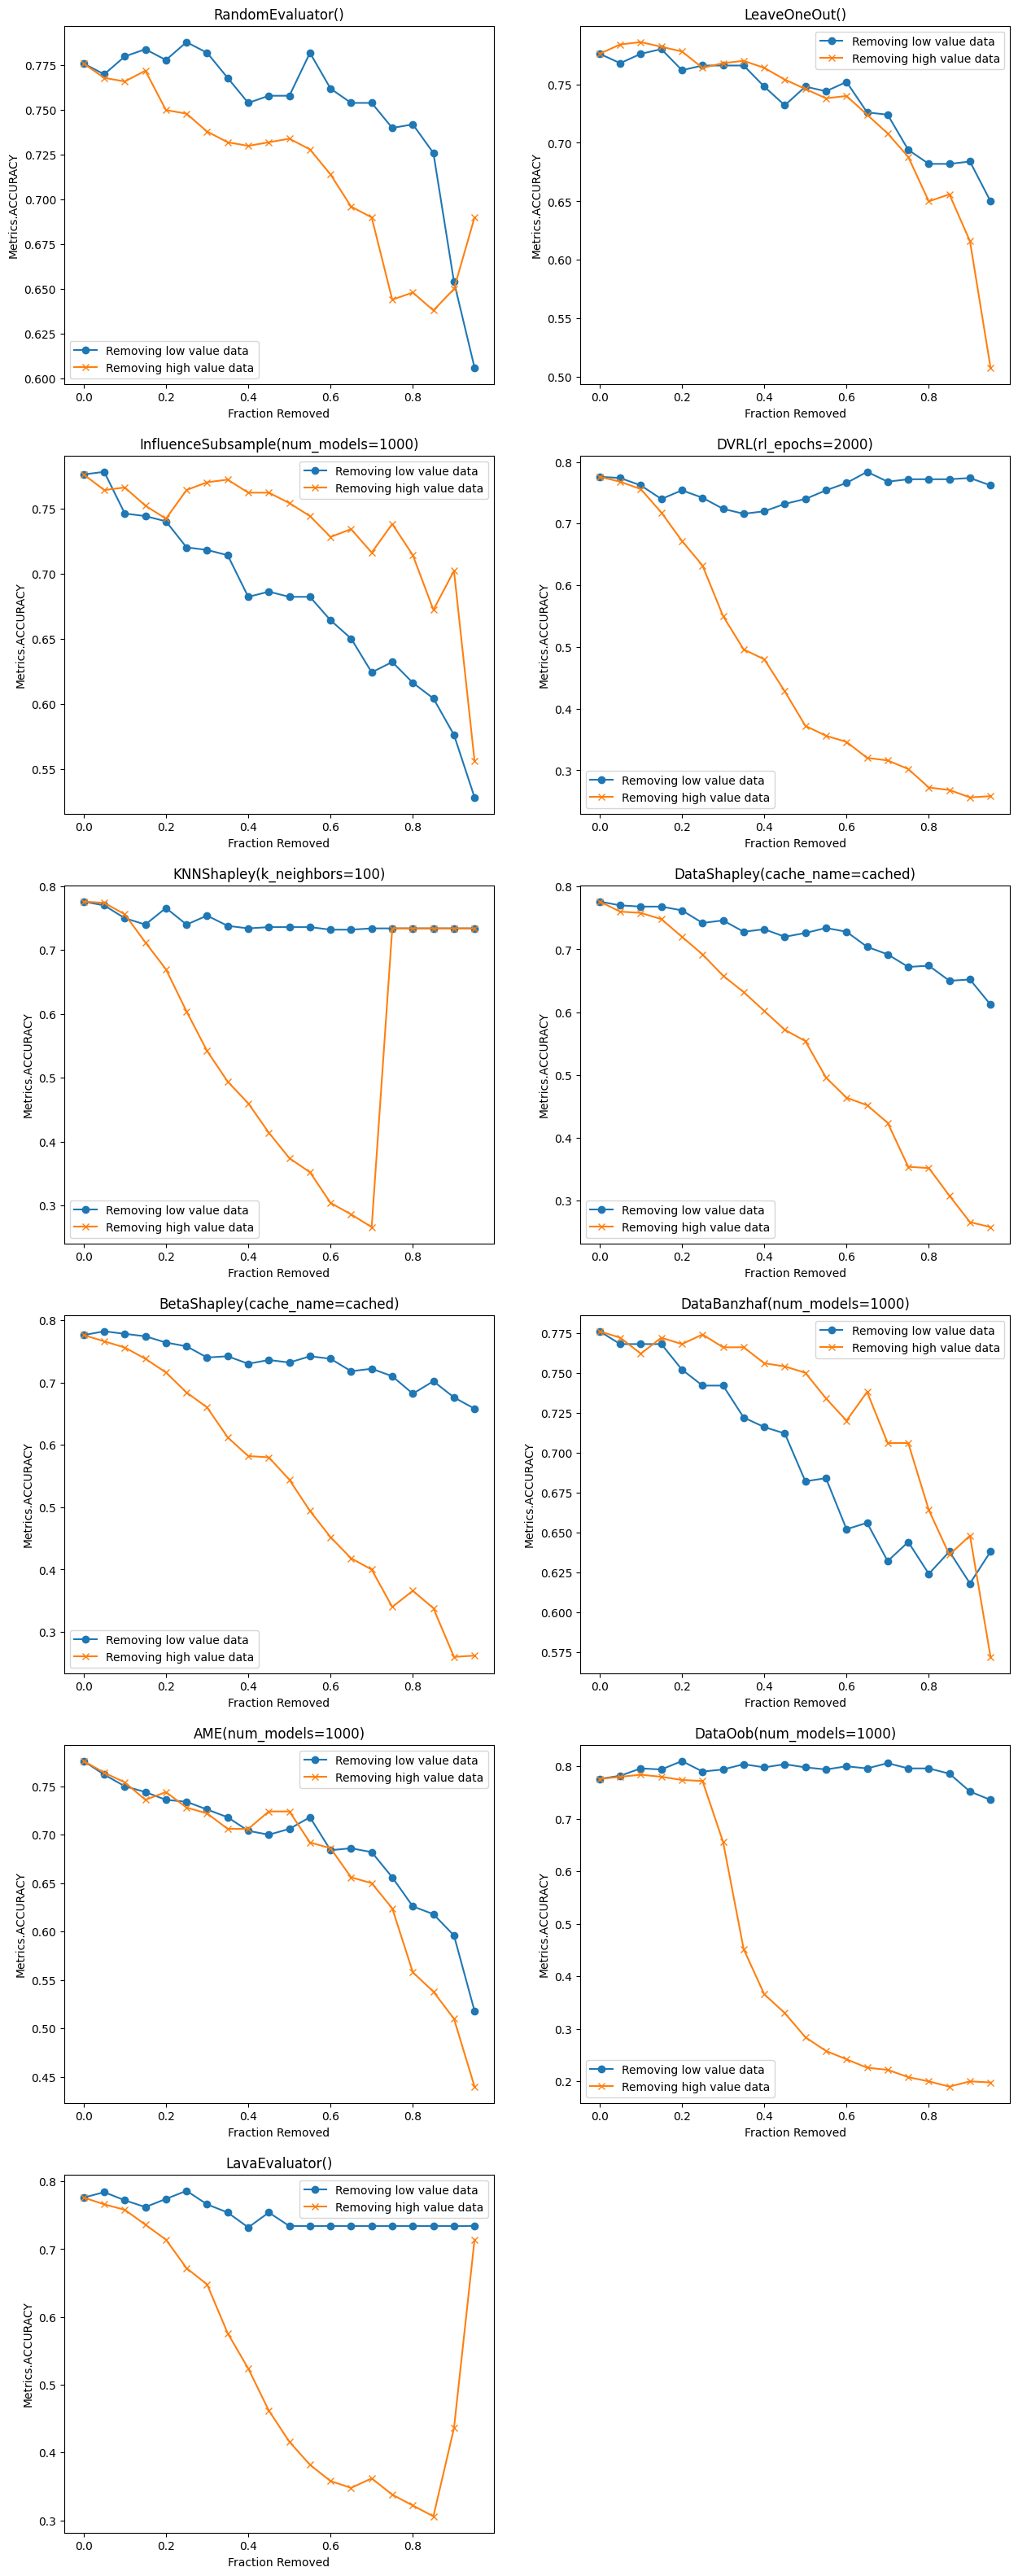

In [8]:
fig = plt.figure(figsize=(15, 40))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.776,0.776,0.0
RandomEvaluator(),0.77,0.768,0.05
RandomEvaluator(),0.78,0.766,0.1
RandomEvaluator(),0.784,0.772,0.15
RandomEvaluator(),0.778,0.75,0.2
...,...,...,...
LavaEvaluator(),0.734,0.338,0.75
LavaEvaluator(),0.734,0.322,0.8
LavaEvaluator(),0.734,0.306,0.85
LavaEvaluator(),0.734,0.436,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),27083,0.436475
RandomEvaluator(),9094,0.549134
RandomEvaluator(),18278,0.362436
RandomEvaluator(),22893,0.203321
RandomEvaluator(),1037,0.489934
...,...,...
LavaEvaluator(),20987,30.181755
LavaEvaluator(),41148,60.190872
LavaEvaluator(),24660,68.272003
LavaEvaluator(),35583,40.120407
